In [327]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader

torch.backends.cudnn.deterministic = True

from tqdm import tqdm

from cifar10_loader import load_and_process_cifar

In [328]:
def get_item(x, is_cuda):
    """get the numpy value from a torch tensor."""
    if is_cuda:
        x = x.cpu().detach().numpy()
    else:
        x = x.detach().numpy()
    return x

def MatConvert(x, device, dtype):
    """convert the numpy to a torch tensor."""
    x = torch.from_numpy(x).to(device, dtype)
    return x

def Pdist2(x, y):
    """compute the paired distance between x and y."""
    x_norm = (x ** 2).sum(1).view(-1, 1)
    if y is not None:
        y_norm = (y ** 2).sum(1).view(1, -1)
    else:
        y = x
        y_norm = x_norm.view(1, -1)
    Pdist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    Pdist[Pdist<0]=0
    return Pdist

In [362]:
def h1_mean_var_gram(Kx, Ky, Kxy, is_var_computed, use_1sample_U=True):
    """compute value of MMD and std of MMD using kernel matrix."""
    Kxxy = torch.cat((Kx,Kxy),1)
    Kyxy = torch.cat((Kxy.transpose(0,1),Ky),1)
    Kxyxy = torch.cat((Kxxy,Kyxy),0)
    nx = Kx.shape[0]
    ny = Ky.shape[0]
    is_unbiased = True
    if is_unbiased:
        xx = torch.div((torch.sum(Kx) - torch.sum(torch.diag(Kx))), (nx * (nx - 1)))
        yy = torch.div((torch.sum(Ky) - torch.sum(torch.diag(Ky))), (ny * (ny - 1)))
        # one-sample U-statistic.
        if use_1sample_U:
            xy = torch.div((torch.sum(Kxy) - torch.sum(torch.diag(Kxy))), (nx * (ny - 1)))
        else:
            xy = torch.div(torch.sum(Kxy), (nx * ny))
        mmd2 = xx - 2 * xy + yy
    else:
        xx = torch.div((torch.sum(Kx)), (nx * nx))
        yy = torch.div((torch.sum(Ky)), (ny * ny))
        # one-sample U-statistic.
        if use_1sample_U:
            xy = torch.div((torch.sum(Kxy)), (nx * ny))
        else:
            xy = torch.div(torch.sum(Kxy), (nx * ny))
        mmd2 = xx - 2 * xy + yy
    if not is_var_computed:
        return mmd2, None, Kxyxy
    hh = Kx+Ky-Kxy-Kxy.transpose(0,1)
    
    V1 = torch.dot(hh.sum(1)/ny,hh.sum(1)/ny) / ny
    V2 = (hh).sum() / (nx) / nx
    varEst = torch.abs(4*(V1 - V2**2))
    if np.isnan(varEst.item()):
        print('yeet')
        return None
    #if  varEst == 0.0:
    #    print('error_var!!'+str(V1))
    return mmd2, varEst, (Kx, Ky, Kxy)#(Kxxy, Kyxy, Kxyxy)

In [363]:
def MMDu(Fea, len_s, Fea_org, sigma, sigma0=0.1, epsilon = 10**(-10), is_smooth=True, is_var_computed=True, use_1sample_U=True):
    """compute value of deep-kernel MMD and std of deep-kernel MMD using merged data."""
    X = Fea[0:len_s, :] # fetch the sample 1 (features of deep networks)
    Y = Fea[len_s:, :] # fetch the sample 2 (features of deep networks)
    X_org = Fea_org[0:len_s, :] # fetch the original sample 1
    Y_org = Fea_org[len_s:, :] # fetch the original sample 2
    L = 1 # generalized Gaussian (if L>1)

    nx = X.shape[0]
    ny = Y.shape[0]
    Dxx = Pdist2(X, X)
    Dyy = Pdist2(Y, Y)
    Dxy = Pdist2(X, Y)
    Dxx_org = Pdist2(X_org, X_org)
    Dyy_org = Pdist2(Y_org, Y_org)
    Dxy_org = Pdist2(X_org, Y_org)
    if is_smooth:
        Kx = (1-epsilon) * torch.exp(-(Dxx / sigma0)**L -Dxx_org / sigma) + epsilon * torch.exp(-Dxx_org / sigma)
        Ky = (1-epsilon) * torch.exp(-(Dyy / sigma0)**L -Dyy_org / sigma) + epsilon * torch.exp(-Dyy_org / sigma)
        Kxy = (1-epsilon) * torch.exp(-(Dxy / sigma0)**L -Dxy_org / sigma) + epsilon * torch.exp(-Dxy_org / sigma)
    else:
        Kx = torch.exp(-Dxx / sigma0)
        Ky = torch.exp(-Dyy / sigma0)
        Kxy = torch.exp(-Dxy / sigma0)
    return h1_mean_var_gram(Kx, Ky, Kxy, is_var_computed, use_1sample_U)

In [364]:
''' Latent space model '''

class ModelLatentF(torch.nn.Module):
    """define deep networks."""
    def __init__(self, x_in, H, x_out):
        """Init latent features."""
        super(ModelLatentF, self).__init__()
        self.restored = False

        self.latent = torch.nn.Sequential(
            torch.nn.Linear(x_in, H, bias=True),
            torch.nn.Softplus(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Softplus(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Softplus(),
            torch.nn.Linear(H, x_out, bias=True),
        )
    def forward(self, input):
        """Forward the LeNet."""
        fealant = self.latent(input)
        return fealant

In [365]:
''' Custom dataset class '''

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.n = len(X)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [366]:
''' Deep Kernel MMD class'''

class DK_MMD:
    def __init__(self, n, X, Y, n_features=10, hidden_dim=20, out_features=20, lr=5e-5, train_epochs=1000, alpha=0.05, batch_size=32, P=None, Q=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.lr = lr
        self.n = n # number of samples in one set
        self.batch_size=batch_size
        self.alpha = alpha
        self.train_epochs = train_epochs
        self.losses = torch.zeros(size=(self.train_epochs,)) # collecting loss data
        self.P, self.Q = P, Q # DEFAULTS TO NONE
        self.oracle = True if self.P is not None else False
        self.dtype = torch.float
        
        if self.oracle:
            print('Distribution oracles provided. Will be using oracles instead of samples.')
            
        # feature map
        self.feature_map = ModelLatentF(n_features, hidden_dim, out_features) 
        self.feature_map = self.feature_map.to(self.device)
        
        # Training stuff
        self.eps_opt = torch.log(MatConvert(np.random.rand(1) * 10 ** (-10), self.device, torch.float))
        self.eps_opt.requires_grad = True
        self.sigma_q = MatConvert(np.ones(1) * np.sqrt(2*n_features), self.device, torch.float)
        self.sigma_q.requires_grad = True
        self.sigma_phi = MatConvert(np.ones(1) * np.sqrt(0.005), self.device, torch.float)
        self.sigma_phi.requires_grad = True
        
        print('n:{}\t d: {}'.format(self.n, n_features))
        print('Epsilon: {:.6f}'.format(self.eps_opt.item()))
        
        self.optimizer = optim.Adam(list(self.feature_map.parameters()) + [self.eps_opt] + [self.sigma_phi] + [self.sigma_q], lr=self.lr)
        # initialize data variables.
        idx = np.random.choice(len(X), self.n, replace=False)
        idy = np.random.choice(len(Y), self.n, replace=False)
        
        self.dataset = CustomDataset(X[idx], Y[idy])
        self.loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=3, pin_memory=True)
    
    def save(self, save_dir, name):
        os.makedirs(save_dir, exist_ok=True)
        torch.save(self.feature_map.state_dict(), os.path.join(save_dir, name))
    
    def load(self, pth):
        try: 
            self.feature_map.load_state_dict(torch.load(pth))
            self.feature_map = self.feature_map.to(self.device)
        except:
            print('Unable to load model, path not found.')
            exit(1)
    
    def train(self):
        ''' Trains the deep kernel MMD'''
        for e in tqdm(range(self.train_epochs)):            
            # Printables
            mmd_value_temp = None
            mmd_std_temp = None
            STAT_u = None
            
            # if using distribution oracles to train, regen every epoch
            if self.oracle:
                X, Y = self.P.sample(self.n), self.Q.sample(self.n)
                self.dataset = CustomDataset(X, Y)
                self.loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=3, pin_memory=True)
                
            for idx, (batch_X, batch_Y) in enumerate(self.loader):
                eps = torch.exp(self.eps_opt) / (1 + torch.exp(self.eps_opt))
                sigma_phi = self.sigma_phi ** 2
                sigma_q = self.sigma_q ** 2
                
                S = np.concatenate((batch_X, batch_Y), axis=0)
                S = MatConvert(S, self.device, self.dtype)
                
                model_output = self.feature_map(S)
                mmd, var, (Kx, Ky, Kxy) = MMDu(model_output, int(len(S)/2), S, sigma=sigma_q, sigma0=sigma_phi, epsilon=eps)
                mmd_value_temp = -1 * (mmd + 1e-8)
                mmd_std_temp = torch.sqrt(var + 1e-8) 
                if mmd_std_temp.item() == 0:
                    print('error 1!!')
                if np.isnan(mmd_std_temp.item()):
                    print('error 2!!')
                    nx = Kx.shape[0]
                    ny = Ky.shape[0]
                    hh = Kx+Ky-Kxy-Kxy.transpose(0,1)
                    print()
                    print(hh)
                    print()
                    V1 = torch.dot(hh.sum(1)/ny,hh.sum(1)/ny) / ny
                    print(V1)
                    print()
                    V2 = (hh).sum() / (nx) / nx
                    print(V2)
                    varEst = 4*(V1 - V2**2) + 1e-8
                    print('varEst', varEst)
                    print('var:', var)
                    stdtemp = torch.sqrt(varEst + 1e-8)
                    print(stdtemp)
                    print(mmd_value_temp)
                    st = torch.div(mmd_value_temp, mmd_std_temp)
                    print(st)
                STAT_u = torch.div(mmd_value_temp, mmd_std_temp)
                self.optimizer.zero_grad()
                STAT_u.backward(retain_graph=True)
                self.optimizer.step()
            if e % 100 ==0:
                print("mmd: ", -1 * mmd_value_temp.item(), "mmd_std: ", mmd_std_temp.item(), "Statistic: ",
                    -1 * STAT_u.item())  # ,"Reg: ", loss1.item()
                
            
        print('Done training!')
        return None
    
    def get_distance(self, X, Y):
        eps = torch.exp(self.eps_opt) / (1 + torch.exp(self.eps_opt))
        if len(X) > len(Y):
            idx = np.random.choice(len(X), len(Y), replace=False)
            X = X[idx]
        S = np.concatenate((X, Y), axis=0)
        S = MatConvert(S, self.device, self.dtype)
        model_output = self.feature_map(S)
        mmd, _, _ = MMDu(model_output, len(X), S, sigma=self.sigma_q ** 2, sigma0=self.sigma_phi ** 2, epsilon=eps)
        mmd = get_item(mmd, True if torch.cuda.is_available() else False)
        return mmd
    

### Load CIFAR10.1 data

In [367]:
from sklearn.decomposition import PCA
def load_cifar10_512():
    with open('data/cifar10_x_train.npy', 'rb') as f:
        x_train = np.load(f)
    #with open('baselines/data/cifar10_x_test.npy', 'rb') as f:
    #    x_test = np.load(f)
    with open('data/cifar10_y_train.npy', 'rb') as f:
        y_train = np.load(f)
    #with open('baselines/data/cifar10_y_test.npy', 'rb') as f:
    #    y_test = np.load(f)
    return x_train, y_train

def load_cifar101_512():
    with open('data/cifar101_x_test.npy', 'rb') as f:
        x_test = np.load(f)
    with open('data/cifar10.1_v6_labels.npy', 'rb') as f:
        y_test = np.load(f)
    return x_test, y_test

def load_and_process_cifar(n_components=10):
    # load datasets -------------------------------
    x_train, y_train = load_cifar10_512()
    x_test, y_test = load_cifar101_512()
    
    xy_train = np.concatenate([x_train, np.expand_dims(y_train, axis=1)], axis=1)
    np.random.shuffle(xy_train)
    x_train, y_train = xy_train[:, :512], xy_train[:,512:]
    
    xy_test = np.concatenate([x_test, np.expand_dims(y_test, axis=1)], axis=1)
    np.random.shuffle(xy_test)
    x_test, y_test = xy_test[:, :512], xy_test[:,512:]
    # PCA -----------------------------------------
    pca = PCA(n_components=n_components)
    pca.fit(x_train)
    x_train_pca, x_test_pca = pca.transform(x_train), pca.transform(x_test)
    print('PCA explained variance ratio: ', sum(pca.explained_variance_ratio_))
    return x_train_pca, x_test_pca, y_train, y_test
    
    
x_train, x_test, y_train, y_test = load_and_process_cifar(n_components=20)

PCA explained variance ratio:  0.8065884494863885


In [368]:
np.random.shuffle(x_test)
x_val, x_test = x_test[:1000], x_test[1000:]
x_train = x_train[np.random.choice(len(x_train), 1000, replace=False)]

In [369]:
mmd_config = {
    'n': 1000,  # lower of the two
    'X': x_train,
    'Y': x_test,
    'n_features': 20,
    'hidden_dim': 32,
    'batch_size': 32,
    'lr': 5e-5,
    'train_epochs': 500,
    'P': None,
    'Q': None
}

In [370]:
mmd = DK_MMD(**mmd_config)

n:1000	 d: 20
Epsilon: -25.962107


In [371]:
mmd.train()

  0%|          | 1/500 [00:00<01:06,  7.50it/s]

mmd:  9.999994610154772e-09 mmd_std:  0.00015780102694407105 Statistic:  6.3370905991178e-05


 20%|██        | 101/500 [00:13<00:53,  7.43it/s]

mmd:  -2.738575312832836e-05 mmd_std:  0.0004345272609498352 Statistic:  -0.06302424520254135


 40%|████      | 201/500 [00:26<00:39,  7.60it/s]

mmd:  -0.0018509689252823591 mmd_std:  0.003556147450581193 Statistic:  -0.5204983353614807


 60%|██████    | 301/500 [00:39<00:25,  7.78it/s]

mmd:  -0.0012094881385564804 mmd_std:  0.005689931567758322 Statistic:  -0.21256637573242188


 80%|████████  | 401/500 [00:52<00:13,  7.54it/s]

mmd:  4.4057971535949036e-05 mmd_std:  0.000263826921582222 Statistic:  0.16699573397636414


100%|██████████| 500/500 [01:06<00:00,  7.55it/s]

Done training!


In [30]:
mmd.save('.', 'mmd_cifar_weights.pth')

In [34]:
mmd.load('baselines/mmd_cifar_weights.pth')

In [381]:
from divergence import permutation_test
flag, distr, est = permutation_test(mmd, x_train, x_val, 500, 0.05, enable_tqdm=True, max_size=200)

100%|██████████| 500/500 [00:00<00:00, 972.51it/s]


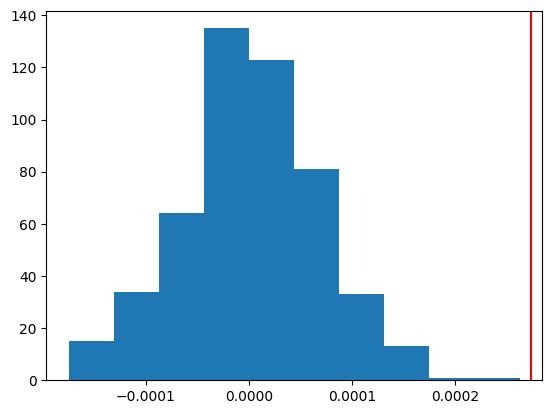

In [382]:
import matplotlib.pyplot as plt
plt.hist(distr)
plt.axvline(est, c='r')

In [383]:
flag

1